# Housing Prices

Using this [Kaggle data](https://www.kaggle.com/anthonypino/melbourne-housing-market/data) create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
melbourne = pd.read_csv('Melbourne_housing.csv')
melbourne.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [92]:
melbourne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31420 entries, 0 to 31419
Data columns (total 21 columns):
Suburb           31420 non-null object
Address          31420 non-null object
Rooms            31420 non-null int64
Type             31420 non-null object
Price            24589 non-null float64
Method           31420 non-null object
SellerG          31420 non-null object
Date             31420 non-null object
Distance         31419 non-null float64
Postcode         31419 non-null float64
Bedroom2         24211 non-null float64
Bathroom         24205 non-null float64
Car              23821 non-null float64
Landsize         20621 non-null float64
BuildingArea     12569 non-null float64
YearBuilt        14294 non-null float64
CouncilArea      31417 non-null object
Lattitude        24434 non-null float64
Longtitude       24434 non-null float64
Regionname       31417 non-null object
Propertycount    31417 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.0+ M

For this model I am interested in the main determinants of house prices. This rules out many non-parametric models which do not supply any interpretable coefficients. A (log)linear model is used.

Dependent variable (Price)
- Price in dollars
- Missing 6,831 observations (21%). There is some overlap with missing observations of Bathroom (1,561), Car (1,654) and Landsize (1,508). However, if all missing variables are dropped it would lead to a loss of observations closer to 40%.
- Outliers: The minimum price of a sold house was AUD85,000 (a very small house). There are many large outliers however (the most expensive house was AUD11m!). To deal with this Price will be transformed on a log-scale.  

Independent variables:

Suburb: There are 348 suburbs unique suburbs. To avoid overfitting only suburbs with more than 200 sales are included (47 suburbs), the rest are set to 'other'. 

Address: All address is assumed to be captured by the suburb feature. While there may be some additional detail linked to the street of the house (e.g. a particular prestigious street) it will not outweigh the complexity added to the model (and strong collinearity with suburb).

Rooms: Integers between 1 and 16. Use lnRooms

Method: Various descriptions of how the property was sold, but 65% of all observations in method which also has a non-null price is simply an indication that the property was, in fact, sold (S: property sold). Other descriptors may influence prices (e.g. SA - sold after auction; SS - sold after auction price not disclosed), but these classifiers don't have a lot of observations and this feature is therefore not included.

Type: h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse (mainly house)

SellerG: Real Estate Agent codes. There are 374 codes. While a skilled agent may be able to obtain a higher price this will still be relatively small compared to the total house costs. SellerG is therefore not included as a feature.

Date: Date sold is not included as a feature. There may be some seasonality to house price sales, but since the dataset only contains 1 year's worth of house prices it is not included. 

Distance: Distance from CBD. Use lnRooms

Regionname: General Region (West, North West, North, North east ...etc). This will have almost perfect correlation with suburb and is therefore excluded.

Propertycount: Number of properties that exist in the suburb. Use lnPropertyCount

Bedroom2 : Scraped # of Bedrooms (from different source). Ignored for now, use Rooms instead 

Bathroom: Number of Bathrooms. Some correlation with rooms (0.6). Use lnBathroom

Car: Number of carspots. Use lnCar

Landsize: There are some outliers in the dataset (maybe a farm?) which are excluded. There are also 2,437 observation where Landsize is set to zero. Of these 1,327 are units where the buildingsize is equal to the landsize. Data is also imputed for house building size (120 observations) and townhouse (66 observations). All other 0 sizes are inputed using average land size for the suburb. Finall, transform feature to ln(Landsize) to deal with outliers.

BuildingArea: There are many missing values of building size and it is therefore not included (at least some of the variation will be captured by Landsizes)

YearBuilt: There are many missing values for the year the house was built and it is therefore not included.

CouncilArea: Governing council for the area is not included as the variance is likely to be captured by the suburb.

Lattitude: Not included (variance picked up by suburb)

Longtitude: Not included (variance picked up by suburb)

## Cleaning the dependent variable

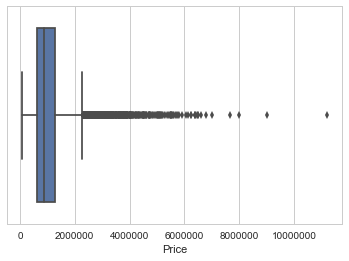

In [93]:
# Distribution showing outliers
sns.set_style("whitegrid")
fig, ax = plt.subplots()
sns.boxplot(melbourne.Price)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

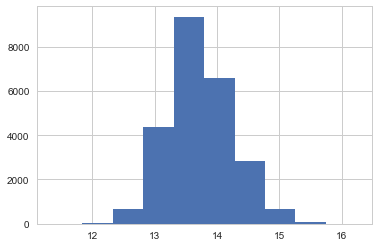

In [94]:
# Distribution of ln(Price)
fig, ax = plt.subplots()
plt.hist(np.log(melbourne.Price.dropna()))
ax.ticklabel_format( style='plain')
plt.show()

In [95]:
# Drop Price NaN
melbourne['Price'].dropna(inplace=True)

# Add new variable
melbourne['lnPrice'] = np.log(melbourne.Price)

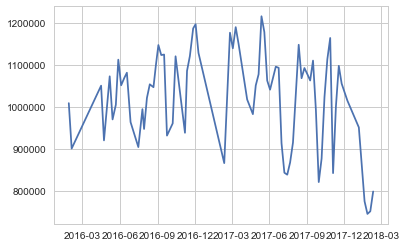

In [96]:
# Convert Date to datetime
melbourne["Date"] = pd.to_datetime(melbourne["Date"],dayfirst=True)

PriceMeans = melbourne.Price.groupby(melbourne.Date).mean()

# Needs to be index rather...

# Plot changes over time
plt.plot(PriceMeans)
plt.show()

## Cleaning feature set

In [97]:
# Create new suburb variable for suburbs with more than 200 sales
suburblist = melbourne.Suburb.value_counts()
tokeep = list(suburblist.index[melbourne.Suburb.value_counts()>200])
print(tokeep)
# Create new suburb feature and set as categorical
melbourne['Suburb_200'] = melbourne.Suburb.where(melbourne.Suburb.isin(tokeep), 'other').astype('category')

# Drop 10 outliers in Landsize
melbourne = melbourne.loc[melbourne.Landsize<40000, :]

# Use BuildingArea where Landsize == 0 and where np.NaN
melbourne['Landsize_adj'] = melbourne.loc[:, 'Landsize']
melbourne.loc[melbourne['Landsize']<0.1, 'Landsize_adj'] = melbourne.loc[melbourne['Landsize']<0.1, 'BuildingArea'].values
#melbourne['Landsize_adj']=melbourne.Landsize.where(melbourne['Landsize']<0.1, melbourne['BuildingArea'])

# For remainder of Landsize_adj == 0 and np.Nan use avg Landsize based on suburb
melbourne['Landsize_adj'].fillna(melbourne.groupby('Suburb')['Landsize'].transform('mean'), inplace=True) 

['Reservoir', 'Bentleigh East', 'Richmond', 'Glen Iris', 'Preston', 'Brighton', 'Kew', 'Brunswick', 'South Yarra', 'Hawthorn', 'Balwyn North', 'Northcote', 'Glenroy', 'Camberwell', 'Coburg', 'Essendon', 'Brighton East', 'St Kilda', 'Pascoe Vale', 'Port Melbourne', 'Malvern East', 'Prahran', 'Balwyn', 'Bentleigh', 'Thornbury', 'Yarraville', 'Surrey Hills', 'Elwood', 'Hawthorn East', 'Carnegie', 'Toorak', 'Hampton', 'Moonee Ponds', 'Footscray', 'Doncaster', 'Ascot Vale', 'Newport', 'Brunswick West', 'Burwood', 'Maribyrnong', 'Armadale', 'Ivanhoe', 'Keilor East', 'Mount Waverley', 'Malvern', 'Craigieburn', 'Glen Waverley']


In [141]:
# Create ln(Buildingsize) on Landsize_adj
melbourne['lnLandsize'] = np.log(melbourne.loc[:, 'Landsize_adj'])

# Set Type as categorical
melbourne['Type'] = melbourne.loc[:,'Type'].astype('category')

# Create suburb dummies
dummies = pd.get_dummies(melbourne.loc[:, ['Suburb_200', 'Type']])

# Drop unused columns and merge with dummies
X = pd.concat([melbourne.drop(['Address', 'Method', 'SellerG', 'Date',
                    'Postcode', 'Bedroom2', 'BuildingArea',
                    'YearBuilt', 'CouncilArea', 'Lattitude',
                    'Longtitude', 'Regionname', 'Price',
                    'Suburb', 'Type', 'Landsize_adj'], axis=1), 
               dummies],axis=1)

In [142]:
# Drop NaN
X.dropna(inplace=True)
print('20,611 originally', X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15914 entries, 1 to 31418
Data columns (total 60 columns):
Rooms                        15914 non-null int64
Distance                     15914 non-null float64
Bathroom                     15914 non-null float64
Car                          15914 non-null float64
Landsize                     15914 non-null float64
Propertycount                15914 non-null float64
lnPrice                      15914 non-null float64
Suburb_200                   15914 non-null category
lnLandsize                   15914 non-null float64
Suburb_200_Armadale          15914 non-null uint8
Suburb_200_Ascot Vale        15914 non-null uint8
Suburb_200_Balwyn            15914 non-null uint8
Suburb_200_Balwyn North      15914 non-null uint8
Suburb_200_Bentleigh         15914 non-null uint8
Suburb_200_Bentleigh East    15914 non-null uint8
Suburb_200_Brighton          15914 non-null uint8
Suburb_200_Brighton East     15914 non-null uint8
Suburb_200_Brunswick    

In [143]:
# Change to log
# Keep zeros as they contain information (change to 0.1)

X['lnRooms'] = np.log(melbourne.loc[:, 'Rooms'])
# 6 distance observations are 0, set to 0.1 instead (next nearest 0.8)
X['Distance'] = X.Distance.where(X.Distance>0.7, 0.1)
X['lnDistance'] = np.log(X.loc[:, 'Distance'])
# 34 Bathroom observations are 0, set to 0.1
X.loc[X.Bathroom==0, 'Bathroom'] = 0.1
X['lnBathroom'] = np.log(X.loc[:, 'Bathroom'])
# 1107 Car observations are 0, set to 0.1
X['Car'] = X.Car.where(X.Car>1, 0.1)
X['lnCar'] = np.log(X.loc[:, 'Car'])
X['lnPropertycount'] = np.log(melbourne.loc[:, 'Propertycount'])

In [145]:
# Drop unused variables, including base categories for categoricals
X.drop(['Rooms', 'Distance', 'Bathroom',
        'Car', 'Propertycount','Landsize',
       'Suburb_200_other', 'Type_u', 'Suburb_200'], axis=1, inplace=True)

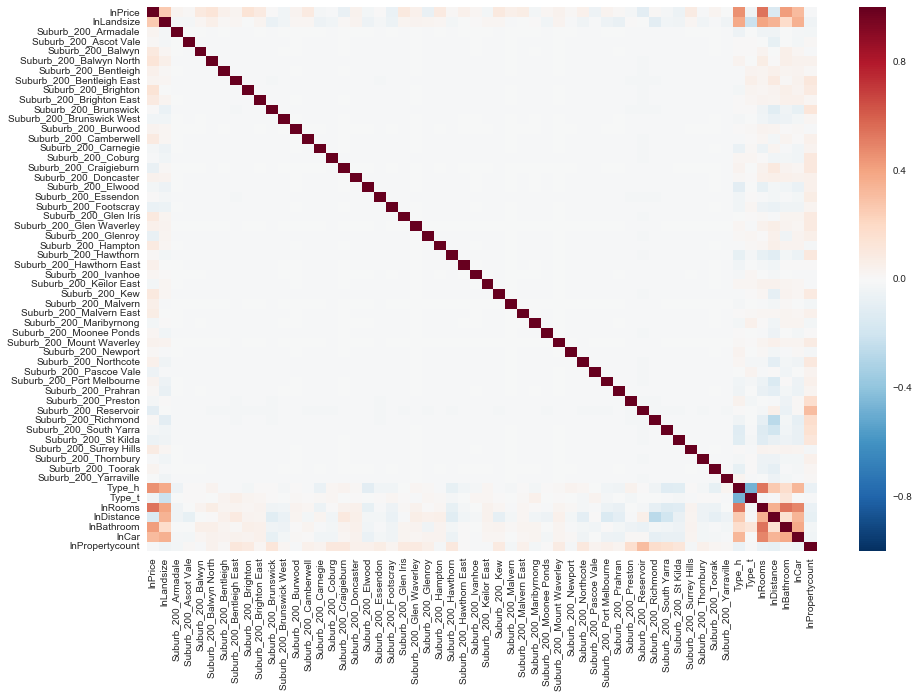

In [146]:
# Check correlations
plt.figure(figsize=(15,10))
sns.heatmap(X.corr())
plt.show()

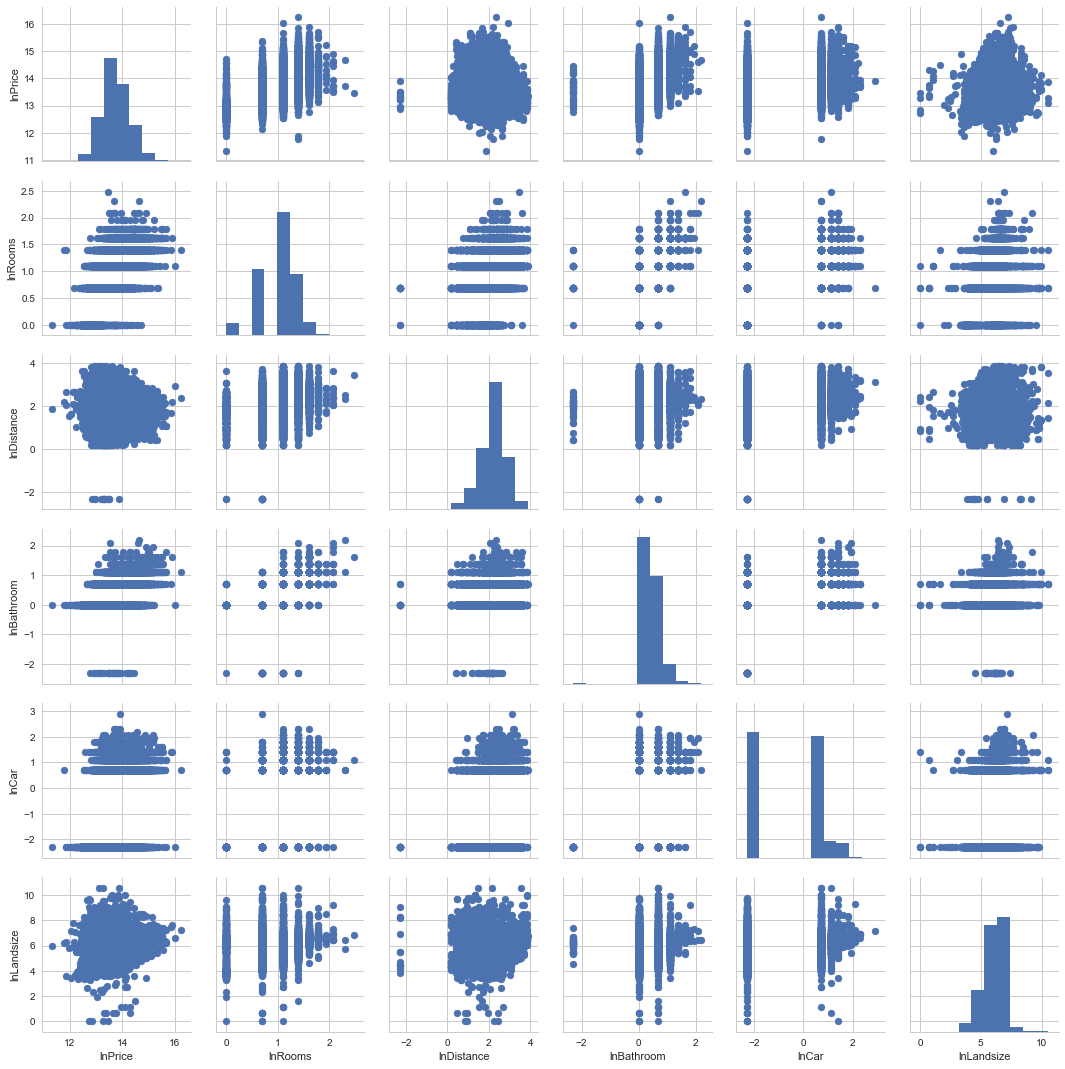

In [147]:
sns.set_style('whitegrid')
g = sns.PairGrid(X.loc[:, ['lnPrice', 'lnRooms', 'lnDistance', 'lnBathroom', 'lnCar', 'lnLandsize']])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()


In [148]:
from sklearn import model_selection

# Split out y
y = X.loc[:, 'lnPrice']
X.drop(['lnPrice'], axis=1, inplace=True)

# Splitting into train and test

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

## OLS

In [159]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

ols = sm.OLS(y_train, X_train)
result = ols.fit()
print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                lnPrice   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     443.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:11:02   Log-Likelihood:                -2481.6
No. Observations:               11935   AIC:                             5075.
Df Residuals:                   11879   BIC:                             5489.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lnLandsize            

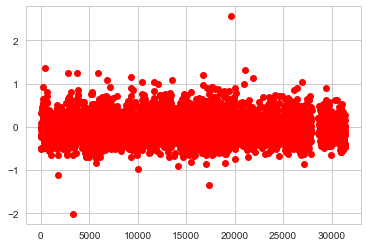

In [157]:
y_hat = result.predict(X_test)
errors = y_test - y_hat

plt.plot(errors, 'ro')
plt.show()

## Conclusion

Perhaps unsurprisingly, landsize, type of house, and number of rooms, bathrooms and carports are all positively related with the price of a house. Some suburbs also add substantial value, and there are clearly some bad neighbourhoods too.

Two interesting findings are that the number of properties in a suburb has a negative relationship (high density housing may be correlated with poorer neighbourhoods) and that distance to city centre is also negatively related to house prices. City centre is likely to have a complex non-linear effect, there are often larger wealthier suburbs far from the city, but generally also some high valued neighbourhoods close to the city (and same for areas with lower houseprices). Much of the effect of distance may therefore be captured by the suburb dummies. 

Overall, the model has a relatively high R^2 at 0.67, given that a house price will also be determined by many individual characteristics (e.g. architecture, other features, or need for repairs).